In [332]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import shapely as shp
from datetime import datetime

from itertools import compress

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

In [333]:
# read in nyc census block shapefiles
nycshp = gp.read_file('data/nycb2010_16c/nycb2010.shp')

# set up cooridnate system
nycshp = nycshp.to_crs(epsg=4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

subway = pd.read_csv('data/subway.csv')

In [334]:
nycshp.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((-74.07920577013249 40.643430783779, ..."
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,POLYGON ((-74.07061992438021 40.61085506708748...
2,50027001000,5,Staten Island,1000,002700,150406.784296,1703.381058,POLYGON ((-74.07524403976554 40.62600632405744...
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((-74.0870879968983 40.61116883127258,..."
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,POLYGON ((-74.07643744511995 40.60100160658919...


In [335]:
#get list of new citibike stations
# read in 2014-2016 citibike data
citi = pd.DataFrame()
for m in list(compress(os.listdir('data'), [('citibike' in i) for i in os.listdir('data')])):
    citinew = pd.read_csv('data/'+m)
    citi = citi.append(citinew, ignore_index = True)


In [336]:
# keep only subscribers
citi = citi[citi['usertype'] == 'Subscriber']

In [337]:
citi_stations = pd.DataFrame()
for i in citi['start station id'].unique():
    citi_stations_unique = citi[citi['start station id'] == i].iloc[0:1,]
    citi_stations = citi_stations.append(citi_stations_unique, ignore_index = True)

In [338]:
citi_stations.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,471,2014-01-01 00:00:06,2014-01-01 00:07:57,2009,Catherine St & Monroe St,40.711174,-73.996826,263,Elizabeth St & Hester St,40.717290,-73.996375,16379,Subscriber,1986,1
1,1494,2014-01-01 00:00:38,2014-01-01 00:25:32,536,1 Ave & E 30 St,40.741444,-73.975361,259,South St & Whitehall St,40.701221,-74.012342,15611,Subscriber,1963,1
2,464,2014-01-01 00:03:59,2014-01-01 00:11:43,228,E 48 St & 3 Ave,40.754601,-73.971879,2022,E 59 St & Sutton Pl,40.758491,-73.959206,16613,Subscriber,1991,1
3,373,2014-01-01 00:05:15,2014-01-01 00:11:28,519,Pershing Square N,40.751884,-73.977702,526,E 33 St & 5 Ave,40.747659,-73.984907,15938,Subscriber,1989,1
4,660,2014-01-01 00:05:18,2014-01-01 00:16:18,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,436,Hancock St & Bedford Ave,40.682166,-73.953990,19830,Subscriber,1990,1


In [339]:
#Convert starttime to timpstamp format
citi_stations['timestamp'] = pd.to_datetime(citi_stations["starttime"])

In [340]:
len(citi_stations)

655

In [341]:
(citi_stations['timestamp'] > '2014-02-01 00:00:00').sum()

326

In [342]:
citi_stations_new = citi_stations[citi_stations['timestamp'] > '2014-02-01 00:00:00']
citi_stations_new.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,timestamp
329,118,2014-03-01 00:46:32,2014-03-01 00:48:30,491,E 24 St & Park Ave S,40.740964,-73.986022,325,E 19 St & 3 Ave,40.736245,-73.984738,19253,Subscriber,1985,1,2014-03-01 00:46:32
330,611,2014-03-01 03:38:07,2014-03-01 03:48:18,321,Cadman Plaza E & Red Cross Pl,40.699918,-73.989718,501,FDR Drive & E 35 St,40.744219,-73.971212,18465,Subscriber,1988,1,2014-03-01 03:38:07
331,320,2014-05-05 15:17:06,2014-05-05 15:22:26,530,11 Ave & W 59 St,40.771522,-73.990541,422,W 59 St & 10 Ave,40.770513,-73.988038,16049,Subscriber,1963,1,2014-05-05 15:17:06
332,8185,3/29/2015 11:04,3/29/2015 13:21,255,NYCBS Depot - SSP,40.646768,-74.016510,321,Cadman Plaza E & Red Cross Pl,40.699918,-73.989718,16626,Subscriber,1975,1,2015-03-29 11:04:00
333,909,7/30/2015 20:36:19,7/30/2015 20:51:29,3180,Brooklyn Bridge Park - Pier 2,40.698780,-73.997120,395,Bond St & Schermerhorn St,40.688070,-73.984106,18062,Subscriber,1971,2,2015-07-30 20:36:19


In [343]:
citi_stations_new = citi_stations_new[["timestamp", "start station id", "start station name", "start station latitude", "start station longitude"]]
citi_stations_new.columns = ['timestamp', 'station_id', 'name', 'lat', 'lon']

# combine lat and lon to one column
citi_stations_new['lonlat']=zip(citi_stations_new.lon, citi_stations_new.lat)

# Create Point Geometry for based on lonlat column
citi_stations_new['geometry']=citi_stations_new[['lonlat']].applymap(lambda x:shp.geometry.Point(x))
citi_stations_new.head()

,timestamp,station_id,name,lat,lon,lonlat,geometry
329,2014-03-01 00:46:32,491,E 24 St & Park Ave S,40.740964,-73.986022,"(-73.98602213, 40.74096374)",POINT (-73.98602212999999 40.74096374)
330,2014-03-01 03:38:07,321,Cadman Plaza E & Red Cross Pl,40.699918,-73.989718,"(-73.98971773, 40.69991755)",POINT (-73.98971773 40.69991755)
331,2014-05-05 15:17:06,530,11 Ave & W 59 St,40.771522,-73.990541,"(-73.990541, 40.771522)",POINT (-73.99054100000001 40.771522)
332,2015-03-29 11:04:00,255,NYCBS Depot - SSP,40.646768,-74.016510,"(-74.01651, 40.646768)",POINT (-74.01651 40.646768)
333,2015-07-30 20:36:19,3180,Brooklyn Bridge Park - Pier 2,40.698780,-73.997120,"(-73.99712, 40.69878)",POINT (-73.99712 40.69878)


In [344]:
# dataframe for rides per station
citi_rides = citi[['start station id', 'tripduration']] # keep duration because we need a column to count with
citi_rides.columns = ['station_id','n_rides']
citi_rides = citi_rides.groupby('station_id').count()

In [345]:
# merge number of rides into station detail table
citi_stations_new = citi_stations_new.merge(citi_rides, how = 'left', left_on = 'station_id', right_index = True)
citi_stations_new = citi_stations_new[["timestamp", "station_id", "geometry", "n_rides"]]

In [346]:
# buffer around each point
citi_stations_new = gp.GeoDataFrame(citi_stations_new, geometry = 'geometry')
citi_stations_new.crs = {'init' :'epsg:4326'}
citi_stations_new = citi_stations_new.to_crs(epsg=2263) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
nycshp = nycshp.to_crs(epsg=2263)

Populating the interactive namespace from numpy and matplotlib


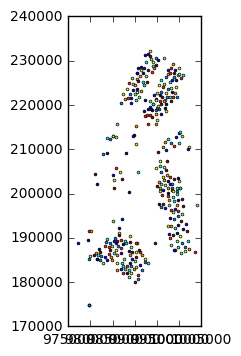

In [347]:
import pylab as pl
%pylab inline

citi_stations_new.plot()

## add in census block demographics data

In [348]:
nycshp['BCTCB2010'] = [i[1:] for i in nycshp['BCTCB2010']]
nycshp.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,0009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((962269.1260375977 173705.5001951929,..."
1,0020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391613 161835.2652098391,..."
2,0027001000,5,Staten Island,1000,002700,150406.784296,1703.381058,"POLYGON ((963363.1166381794 167356.3334471463,..."
3,0040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((960069.9965820312 161953.6936156093,..."
4,0064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,"POLYGON ((963023.8917846683 158246.7522093526,..."


In [349]:
nycshp.BCTCB2010[nycshp.BoroName == 'Staten Island'] = '36085' + nycshp.BCTCB2010[nycshp.BoroName == 'Staten Island']
nycshp.BCTCB2010[nycshp.BoroName == 'Manhattan'] = '36061' + nycshp.BCTCB2010[nycshp.BoroName == 'Manhattan']
nycshp.BCTCB2010[nycshp.BoroName == 'Queens'] = '36081' + nycshp.BCTCB2010[nycshp.BoroName == 'Queens']
nycshp.BCTCB2010[nycshp.BoroName == 'Brooklyn'] = '36047' + nycshp.BCTCB2010[nycshp.BoroName == 'Brooklyn']
nycshp.BCTCB2010[nycshp.BoroName == 'Bronx'] = '36005' + nycshp.BCTCB2010[nycshp.BoroName == 'Bronx']


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [350]:
# check for each citibike stations to see what CB they belong to
a = []
citi_stations_new['tracts'] = 0
for i in range(len(citi_stations_new)):
    # includes stations not in Manhattan, return 0 for CB. 
    try: 
        a.append([k for k in nycshp[nycshp.geometry.intersects(citi_stations_new.iloc[i].geometry.buffer(150))].BCTCB2010])
    except: 
        a.append(0)
    print '\r',"%",str((i+1)*100./len(citi_stations_new))[:4],
citi_stations_new['tracts']=a
citi_stations_new = citi_stations_new.reindex()

% 100.


In [351]:
citi_stations_new = citi_stations_new[["station_id", "n_rides", "geometry", "tracts"]]
citi_stations_new.tail()

,station_id,n_rides,geometry,tracts
650,3376,8,POINT (994715.3064021288 217886.5798987585),"[360610118007000, 360610118008000]"
651,3332,4,POINT (986804.3775273946 187744.0633820376),"[360470075001002, 360470075002001, 36047007500..."
652,3435,25,POINT (985369.898278631 201162.7875198031),"[360610041002001, 360610041003000, 36061004100..."
653,3436,28,POINT (981460.0609268496 202072.6557350773),"[360610039001018, 360610039001019, 36061003900..."
654,3434,1,POINT (990568.0402704081 227188.645131195),"[360610175001003, 360610175002000, 36061017500..."


In [352]:
df = gp.read_file('data/cb_dist/cb_dist_all_nyc.shp')

In [353]:
demo = pd.read_csv('data/demo.csv')
df.tail(10)

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,dist_tohom,dist_towor,geometry,residents,workers
20896,360810006001003,4,Queens,1003,000600,159213.793766,1788.364426,4.590714,6.182529,"POLYGON ((1022946.834228517 188809.5380369891,...",73,5
20897,360810008002005,4,Queens,2005,000800,167035.873429,1822.279534,2.303593,5.757164,"POLYGON ((1023190.786987306 188905.8498045706,...",62,5
20898,360610243021005,1,Manhattan,1005,024302,283063.278099,2468.026395,4.061102,5.156696,"POLYGON ((1001755.348388672 241636.4550291704,...",455,26
20899,360810471001002,4,Queens,1002,047100,149379.347933,1644.308065,5.151350,4.762213,"POLYGON ((1018715.723999023 209626.3394285868,...",112,1
20900,360810471001005,4,Queens,1005,047100,147595.350818,1668.283412,3.349474,4.674031,"POLYGON ((1018345.718627932 209277.4714476391,...",403,14
20901,360050216023002,2,Bronx,3002,021602,224172.113792,2446.404530,5.468028,6.163652,"POLYGON ((1022728.471984864 244951.2739989016,...",316,66
20902,360050216022001,2,Bronx,2001,021602,146869.945755,1877.106694,5.377462,6.431716,"POLYGON ((1022678.206420899 244466.9444090589,...",165,18
20903,360050216024000,2,Bronx,4000,021602,324298.032947,3013.710468,5.122460,7.602267,"POLYGON ((1022565.290222168 244493.1238524288,...",295,7
20904,360810086001014,4,Queens,1014,008600,167489.726871,1850.958176,5.311830,5.162866,"POLYGON ((1028295.05999756 185832.5723997795, ...",30,2
20905,360810086002005,4,Queens,2005,008600,180746.889134,1909.003325,3.612624,4.883463,"POLYGON ((1028386.265441894 185586.3686033974,...",32,16


In [354]:
demo.head()

,geoid,pop,bike,commute_time,income_pc,no_vehicle_rent,no_vehicle_own
0,360594144003,870,0,312,8291.0,97,0
1,360594141002,1569,0,674,24402.0,0,0
2,360594136001,965,0,428,31416.0,0,25
3,360594142024,1028,0,456,20567.0,60,0
4,360594142022,1197,0,621,16936.0,41,0


In [355]:
df['BCTCB2010'] = df['BCTCB2010'].astype('int')
df['geoid'] = [i[0:-3] for i in df['BCTCB2010'].astype('str')]
df = df.dissolve(by = 'geoid', aggfunc = 'mean', as_index = False)
df.head()

,geoid,geometry,BCTCB2010,Shape_Area,Shape_Leng,dist_tohom,dist_towor,residents,workers
0,360050002001,(POLYGON ((1022729.262390137 235476.9921995869...,3.600500e+14,165502.387824,1902.630188,1.689186,5.015495,38.000000,4.500000
1,360050002002,(POLYGON ((1024075.043823242 234930.1988035945...,3.600500e+14,151808.843054,1804.746075,2.009876,4.787413,42.666667,4.333333
2,360050002003,(POLYGON ((1023807.029235841 233647.6192137522...,3.600500e+14,116814.153846,1303.183315,2.641470,4.547958,17.800000,5.000000
3,360050004001,"POLYGON ((1024174.505615234 234947.731396367, ...",3.600500e+14,188559.140013,2020.183073,7.964882,6.732080,216.000000,4.000000
4,360050004002,"POLYGON ((1024604.209411622 234226.9358031033,...",3.600500e+14,228050.083161,2126.865002,4.454643,5.820165,54.000000,12.666667


In [356]:
# get station demographics and distance
citi_demo = pd.DataFrame()
for i in range(len(citi_stations_new)):
    dists = transpose(pd.DataFrame(df[np.in1d(df.geoid, [j[0:-3] for j in citi_stations_new.tracts.iloc[i]])].mean()))
    dists.index = [citi_stations_new.station_id.iloc[i]]
    dems = transpose(pd.DataFrame(demo[np.in1d(demo.geoid.astype('str'), [j[0:-3] for j in citi_stations_new.tracts.iloc[i]])].mean()))
    dems.index = [citi_stations_new.station_id.iloc[i]]
    citi_new = dists.merge(dems, left_index = True, right_index = True)
    citi_demo = citi_demo.append(citi_new[['bike','commute_time','dist_tohom','dist_towor',\
                                           'income_pc','no_vehicle_own','no_vehicle_rent','pop','workers', 'residents']])

In [357]:
citi_demo = citi_demo.dropna()
citi_demo.tail()

,bike,commute_time,dist_tohom,dist_towor,income_pc,no_vehicle_own,no_vehicle_rent,pop,workers,residents
3376,0.0,259.500000,5.471072,1.644166,115025.500000,32.500000,215.500000,607.0,425.500000,220.000000
3332,21.0,503.000000,3.722381,4.184759,45486.500000,76.000000,169.000000,1059.0,41.333333,158.833333
3435,7.5,478.500000,5.678337,2.720969,27385.500000,36.500000,417.000000,1295.0,442.833333,161.333333
3436,9.0,643.666667,5.251911,2.648983,115471.333333,144.333333,322.666667,1362.0,1579.560784,258.917647
3434,17.0,785.000000,6.255674,3.291743,84200.500000,258.250000,210.500000,1624.5,281.375000,341.125000


In [358]:
df.head()

,geoid,geometry,BCTCB2010,Shape_Area,Shape_Leng,dist_tohom,dist_towor,residents,workers
0,360050002001,(POLYGON ((1022729.262390137 235476.9921995869...,3.600500e+14,165502.387824,1902.630188,1.689186,5.015495,38.000000,4.500000
1,360050002002,(POLYGON ((1024075.043823242 234930.1988035945...,3.600500e+14,151808.843054,1804.746075,2.009876,4.787413,42.666667,4.333333
2,360050002003,(POLYGON ((1023807.029235841 233647.6192137522...,3.600500e+14,116814.153846,1303.183315,2.641470,4.547958,17.800000,5.000000
3,360050004001,"POLYGON ((1024174.505615234 234947.731396367, ...",3.600500e+14,188559.140013,2020.183073,7.964882,6.732080,216.000000,4.000000
4,360050004002,"POLYGON ((1024604.209411622 234226.9358031033,...",3.600500e+14,228050.083161,2126.865002,4.454643,5.820165,54.000000,12.666667


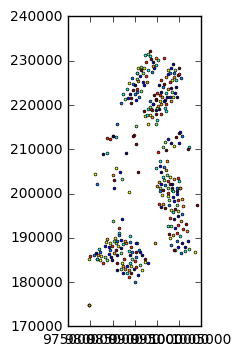

In [359]:
citi_stations_new = citi_stations_new.merge(citi_demo, left_on = 'station_id', right_index = True)
citi_stations_new.plot()

## add distance to subway

In [360]:
# combine lat and lon to one column
# Create Point Geometry for based on lonlat column
subway['lonlat']=zip(subway['Station Longitude'], subway['Station Latitude'])
subway['geometry']=subway[['lonlat']].applymap(lambda x:shp.geometry.Point(x))
subway = gp.GeoDataFrame(subway[['geometry']], geometry = 'geometry')

# handle coordinate system
subway.crs = {'init' :'epsg:4326'}
subway = subway.to_crs(epsg=2263)
subway.head()

,geometry
0,POINT (984779.6435399343 179876.8295590221)
1,POINT (984779.6435399343 179876.8295590221)
2,POINT (983265.2682330192 177963.0294655868)
3,POINT (983265.2682330192 177963.0294655868)
4,POINT (983265.2682330192 177963.0294655868)


In [361]:
# are citibikes near subway stations? near = within a quarter mile
a = []
b = []
citi_stations_new['subway_ct'] = 0
citi_stations_new['subway_dist'] = 0
for i in range(len(citi_stations_new)):
    # includes stations not in Manhattan, return 0 for CB. 
    b.append(subway.distance(citi_stations_new.iloc[i].geometry).min() / 5280)
    try: 
        a.append(len(subway[subway.geometry.intersects(citi_stations_new.iloc[i].geometry.buffer(5280/4))]))
    except: 
        a.append(0)
    print '\r',"%",str((i+1)*100./len(citi_stations_new))[:4],
citi_stations_new['subway_ct'] = a
citi_stations_new['subway_dist'] = b
citi_stations_new = citi_stations_new.reindex()

% 100.


In [362]:
# how dense are citibike stations? near = within a quarter mile
a = []
citi_stations_new['citi_ct'] = 0
for i in range(len(citi_stations_new)):
    # includes stations not in Manhattan, return 0 for CB. 
    try: 
        a.append(len(citi_stations_new[citi_stations_new.geometry.intersects(citi_stations_new.iloc[i].geometry.buffer(2 * 5280))]))
    except: 
        a.append(0)
    print '\r',"%",str((i+1)*100./len(citi_stations_new))[:4],
citi_stations_new['citi_ct'] = a
citi_stations_new = citi_stations_new.reindex()

% 100.


In [363]:
citi_stations_new.head()

,station_id,n_rides,geometry,tracts,bike,commute_time,dist_tohom,dist_towor,income_pc,no_vehicle_own,no_vehicle_rent,pop,workers,residents,subway_ct,subway_dist,citi_ct
329,491,97876,POINT (988123.4138740347 209229.9971760014),"[360610068001003, 360610056001005, 36061006800...",0.0,685.0,5.745953,1.546906,108788.666667,93.333333,424.0,996.666667,1270.277778,189.277778,24,0.081701,50
330,321,14196,POINT (987101.0798574506 194275.467285947),"[360470013001003, 360470013001004, 36047001300...",0.0,818.0,6.473488,2.296295,69243.000000,496.000000,97.0,1477.000000,134.666667,224.666667,6,0.058556,71
331,530,69145,POINT (986869.9855586613 220363.1983025315),"[360610151004005, 360610147001002, 36061014700...",0.0,1810.0,5.505930,2.147639,95493.500000,75.500000,1160.5,3100.500000,246.500000,780.000000,0,0.456680,85
332,255,497,POINT (979668.4382618705 174911.8334632019),"[360470020002000, 360470020002001]",0.0,435.0,6.331385,4.757612,22645.000000,54.000000,75.0,767.000000,182.500000,64.500000,5,0.175152,8
333,3180,3676,POINT (985048.5833977 193860.8698218935),"[360470003015000, 360470003015001, 36047000301...",0.0,322.0,6.854920,2.787957,186348.000000,84.000000,27.0,667.000000,45.500000,43.000000,2,0.230439,68


In [364]:
# export final data
citi_stations_new.drop('tracts',axis = 1, inplace = True)

if not os.path.exists('data/citi_stations_new/'):
    os.makedirs('data/citi_stations_new/')
    
citi_stations_new.to_file('data/citi_stations_new/citi_stations_new.shp')

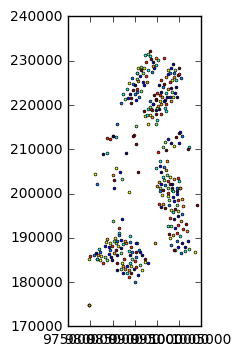

In [365]:
citi_stations_new.plot()